# SVD Method - Practical Session

## Improvements


---
December 19

*   Checked duplicates by userId and movieId
*   Filled by 0 and mean (+ normalization) 
*   Another method was applied

---
January 9

* Changed from user mean to item mean when filling by mean
* Searched the difference between Pearson Correlation and Cosine similarity
* Two metrics were experienced on a different implementation




---


Cosine similarity ensures that the similarity is not fully decided only by the (potentially small) subset of items the two users **have in common**. This is **not natively present** in Pearson correlation (although it can be added by significance weighting). So, in contexts where users tend to have **very differing sets of items** in their profiles, Cosine similarity may perform better, in principle.

Cosine Similarity
<div>
<img src="https://miro.medium.com/max/1400/1*LfW66-WsYkFqWc4XYJbEJg.png" width="500"/>
</div>

Pearson Correlation
<div>
<img src="https://editor.analyticsvidhya.com/uploads/39170Formula.JPG" width="600"/>
</div>

## Loading and Exploring Dataset

In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

movies = pd.read_csv("/content/drive/MyDrive/Guided Research/SVD_Dataset/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Guided Research/SVD_Dataset/ratings.csv")

movies.shape
ratings.shape

(100836, 4)

In [2]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


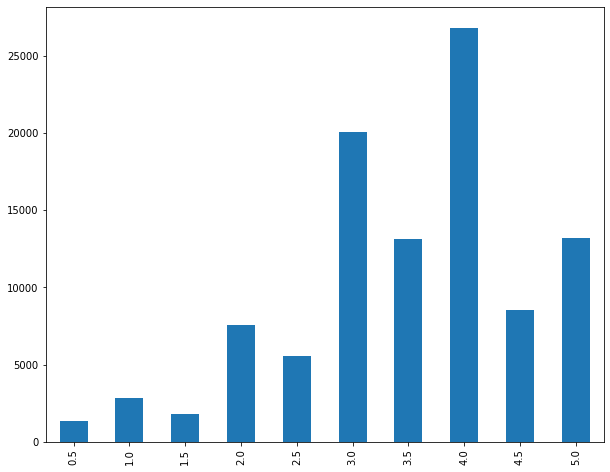

In [4]:
ratings['rating'].value_counts().sort_index().plot(kind='bar', figsize=(10,8))

In [5]:
# Checking null values

movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
# Checking duplicate values
# As the result shows, there is no duplicate in both dataframes

movies[movies.duplicated('movieId')]

,movieId,title,genres


In [8]:
ratings[ratings.duplicated(['userId', 'movieId'])]

,userId,movieId,rating,timestamp


In [9]:
print("Total number of movies:", len(movies["movieId"].unique()))
print("Total number of users:", len(ratings["userId"].unique()))
print("Total number of ratings:", len(ratings["rating"]))
print("Rating values:\n", np.sort(ratings["rating"].unique()))

Total number of movies: 9742
Total number of users: 610
Total number of ratings: 100836
Rating values:
 [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


## Preprocessing

In [10]:
# Train and test split

test = pd.DataFrame(columns=ratings.columns)
train = pd.DataFrame(columns=ratings.columns)

TEST_RATIO = 0.2

users = ratings["userId"].unique()

for user in users:
  
    temp = ratings[ratings['userId'] == user]
    n = len(temp)
    test_size = int(TEST_RATIO * n)

    temp = temp.sort_values('timestamp').reset_index()
    temp.drop('index', axis=1, inplace=True)
    
    dummy_test = temp.iloc[n-1-test_size :]
    dummy_train = temp.iloc[: n-2-test_size]
    
    test = pd.concat([test, dummy_test])
    train = pd.concat([train, dummy_train])

test.shape
train.shape

(20550, 4)

(79676, 4)

In [11]:
# Creating the User Rating Matrix (URM) for train and test sets

# Filling missing cells by 0

urm_test_0 = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

urm_train_0 = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

# Filling missing cells by mean of each column for test set

urm_test_mean = test.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)
urm_test_mean.fillna(urm_test_mean.mean(axis=1), inplace=True)

# Normalization
urm_test_mean = urm_test_mean.subtract(urm_test_mean.mean(axis=1), axis = 'rows')

# Filling missing cells by mean of each column for train set

urm_train_mean = train.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

urm_train_mean_nofill = urm_train_mean.copy()
urm_train_mean.fillna(urm_train_mean.mean(axis=1), inplace=True)

# Normalization
urm_train_mean = urm_train_mean.subtract(urm_train_mean.mean(axis=1), axis = 'rows')

In [12]:
urm_train_0

movieId,1,2,3,4,5,6,7,8,9,10,...,188301,189043,189111,193565,193567,193571,193573,193579,193581,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
urm_train_mean

movieId,1,2,3,4,5,6,7,8,9,10,...,188301,189043,189111,193565,193567,193571,193573,193579,193581,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.141539,-0.017552,0.141539,-0.226882,-0.240814,0.141539,-0.458461,-0.247350,-0.287032,-0.522097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.695617,0.172395,-0.651847,-0.036935,-0.050867,-0.140514,-0.268514,-0.057403,-0.097085,-0.332150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.741826,0.218604,-0.605638,0.009274,-0.004658,-0.094305,-0.222305,-0.011194,-0.050876,-0.285941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.722739,0.199518,-0.624725,-0.009812,-0.023744,-0.113391,-0.241391,-0.030280,-0.069963,-0.305028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.350344,0.191253,-0.632990,-0.018077,-0.032009,-0.121656,-0.249656,-0.038545,-0.078228,-0.313293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.651417,0.128196,-0.696047,-0.081134,-0.095066,-0.184713,-1.212713,-0.101602,-0.141285,-0.376350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.662133,0.138912,-0.685330,-0.070418,-0.084350,-0.173997,-0.301997,-0.090886,-0.130568,-0.365633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,-0.784327,-1.284327,-1.284327,0.347252,0.333320,0.243673,0.115673,0.326784,0.287101,0.715673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Building SVD

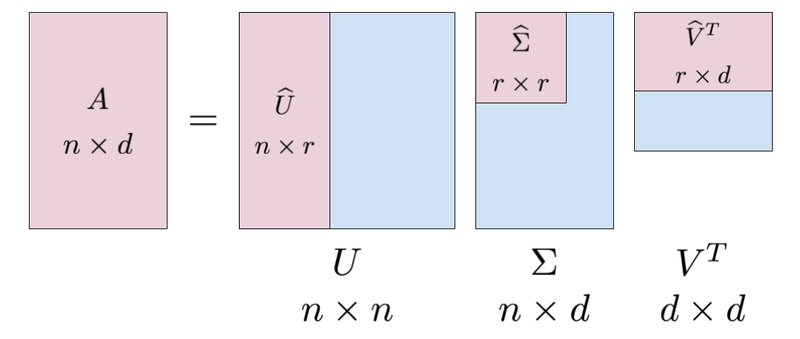

In [14]:
# Calculating movie ratings means and decreased version user rating matrix 0 version

A = urm_train_0.values
user_ratings_mean = np.mean(A, axis = 1)
R_smaller = A - user_ratings_mean.reshape(-1, 1)

from scipy.sparse.linalg import svds

U, sigma, Vt = svds(R_smaller, k = 50)

# Converting value array to diagonal matrix for sigma
sigma = np.diag(sigma)

# Essential SVD operation
users_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds_0 = pd.DataFrame(users_predicted_ratings, columns = urm_train_0.columns)
preds_0

movieId,1,2,3,4,5,6,7,8,9,10,...,188301,189043,189111,193565,193567,193571,193573,193579,193581,193609
0,3.053135,1.000465,1.380451,-0.081360,0.471379,1.932838,-0.246890,-0.102519,0.381520,1.613419,...,-0.065238,0.004109,0.003222,0.012769,0.012165,0.013373,0.013373,0.012769,0.013373,-0.069446
1,0.048207,-0.055988,0.060941,0.001076,0.099369,-0.137085,0.094639,-0.005322,0.037995,-0.118270,...,0.010341,-0.000283,0.000393,0.011942,0.009713,0.014171,0.014171,0.011942,0.014171,0.022924
2,0.027848,0.011036,0.023295,0.003286,-0.009056,0.129497,-0.023473,0.013664,0.027126,0.038815,...,0.024284,0.010021,0.010055,0.008254,0.008482,0.008026,0.008026,0.008254,0.008026,0.012237
3,2.279296,-0.079349,-0.006925,0.096253,0.587894,0.509929,0.720908,0.057060,-0.038182,-0.375584,...,0.078566,-0.014120,-0.016407,0.002825,0.002038,0.003612,0.003612,0.002825,0.003612,-0.052300
4,1.577508,0.793504,0.105362,0.034852,0.222664,0.464910,0.133883,0.037831,-0.021767,0.880905,...,0.031004,0.006548,0.007924,-0.001736,-0.001536,-0.001937,-0.001937,-0.001736,-0.001937,-0.003570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.273989,-0.334981,-0.152494,0.040837,0.005633,-0.299778,2.233985,0.023919,-0.002724,-0.478998,...,0.039756,0.006687,0.005392,0.003066,0.004508,0.001623,0.001623,0.003066,0.001623,0.028252
606,2.132942,1.061188,-0.168843,-0.080735,-0.240564,1.310238,-0.401662,-0.037070,0.091218,1.679875,...,-0.005239,-0.000397,0.000349,-0.027013,-0.023744,-0.030282,-0.030282,-0.027013,-0.030282,-0.018665
607,0.920483,2.118554,1.970488,-0.024541,0.121371,1.684968,0.406978,0.054444,0.231330,3.013173,...,-0.175637,0.025926,0.031424,-0.016582,-0.014436,-0.018727,-0.018727,-0.016582,-0.018727,0.047478
608,0.701298,0.538889,-0.022208,-0.001958,0.051991,0.164354,-0.095324,-0.022197,-0.015950,1.335839,...,-0.020040,0.007005,0.007802,0.003771,0.003664,0.003878,0.003878,0.003771,0.003878,0.010802


In [15]:
# Calculating movie ratings means and decreased version user rating matrix mean version

A = urm_train_mean.values
user_ratings_mean = np.mean(A, axis = 1)
R_smaller = A - user_ratings_mean.reshape(-1, 1)

U, sigma, Vt = svds(R_smaller, k = 50)

# Converting value array to diagonal matrix for sigma
sigma = np.diag(sigma)

# Essential SVD operation
users_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds_mean = pd.DataFrame(users_predicted_ratings, columns = urm_train_mean.columns)
preds_mean

movieId,1,2,3,4,5,6,7,8,9,10,...,188301,189043,189111,193565,193567,193571,193573,193579,193581,193609
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print("Dimensions of user rating matrix:", urm_train_0.shape)
print("Dimensions of left singular matrix:", U.shape)
print("Dimensions of right singular matrix:", Vt.shape)

Dimensions of user rating matrix: (610, 8204)
Dimensions of left singular matrix: (610, 50)
Dimensions of right singular matrix: (50, 8204)


## Making Prediction

In [17]:
def recommend_movies(preds, userID, movies_df, original_ratings_df, num_recommendations=5):

    user_row_num = userID - 1
    sorted_predictions = preds.iloc[user_row_num].sort_values(ascending=False)

    # Getting the user's data and merging in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                 sort_values(['rating'], ascending=False))

    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_predictions).reset_index(), 
                       how = 'left', left_on = 'movieId', right_on = 'movieId').rename(columns = {user_row_num: 'Predictions'}).sort_values('Predictions',
                       ascending = False).iloc[:num_recommendations, :-1]

    return user_full, recommendations

In [18]:
# Quick calculation to find the user who has the least number of observations
array = ratings['userId'].value_counts()

USER_TO_TEST = array.tail(1).index[0]
RECOMMENDATION_NUM = 5

print(f"User ID who has least movie interaction: {USER_TO_TEST}")
print(f"Interaction number: {int(array.tail(1))}")

already_rated_0, recommended_movies_svd_0 = recommend_movies(preds_0, USER_TO_TEST, movies, ratings, RECOMMENDATION_NUM)
already_rated_mean, recommended_movies_svd_mean = recommend_movies(preds_mean, USER_TO_TEST, movies, ratings, RECOMMENDATION_NUM)

User ID who has least movie interaction: 53
Interaction number: 20


In [19]:
already_rated_0

,userId,movieId,rating,timestamp,title,genres
0,53,203,5.0,1237748081,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
1,53,249,5.0,1237748109,Immortal Beloved (1994),Drama|Romance
18,53,3100,5.0,1237748090,"River Runs Through It, A (1992)",Drama
17,53,2686,5.0,1237748068,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery
16,53,2616,5.0,1237748059,Dick Tracy (1990),Action|Crime
15,53,1982,5.0,1237748071,Halloween (1978),Horror
14,53,1441,5.0,1237748056,Benny & Joon (1993),Comedy|Romance
13,53,1298,5.0,1237748074,Pink Floyd: The Wall (1982),Drama|Musical
12,53,1256,5.0,1237748093,Duck Soup (1933),Comedy|Musical|War
11,53,1125,5.0,1237748096,"Return of the Pink Panther, The (1975)",Comedy|Crime


In [20]:
recommended_movies_svd_0

,movieId,title,genres
275,318,"Shawshank Redemption, The (1994)",Crime|Drama
2092,2804,"Christmas Story, A (1983)",Children|Comedy
986,1302,Field of Dreams (1989),Children|Drama|Fantasy
2177,2918,Ferris Bueller's Day Off (1986),Comedy
2085,2797,Big (1988),Comedy|Drama|Fantasy|Romance


In [21]:
recommended_movies_svd_mean

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Visualization (completed before)

In [ ]:
# Concatenating the already rated rows with the recommendations of SVD
test_user_movies = pd.concat([already_rated[['movieId', 'title', 'genres']], recommendations])

In [ ]:
test_user_movies

,movieId,title,genres
0,203,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
1,249,Immortal Beloved (1994),Drama|Romance
18,3100,"River Runs Through It, A (1992)",Drama
17,2686,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery
16,2616,Dick Tracy (1990),Action|Crime
15,1982,Halloween (1978),Horror
14,1441,Benny & Joon (1993),Comedy|Romance
13,1298,Pink Floyd: The Wall (1982),Drama|Musical
12,1256,Duck Soup (1933),Comedy|Musical|War
11,1125,"Return of the Pink Panther, The (1975)",Comedy|Crime


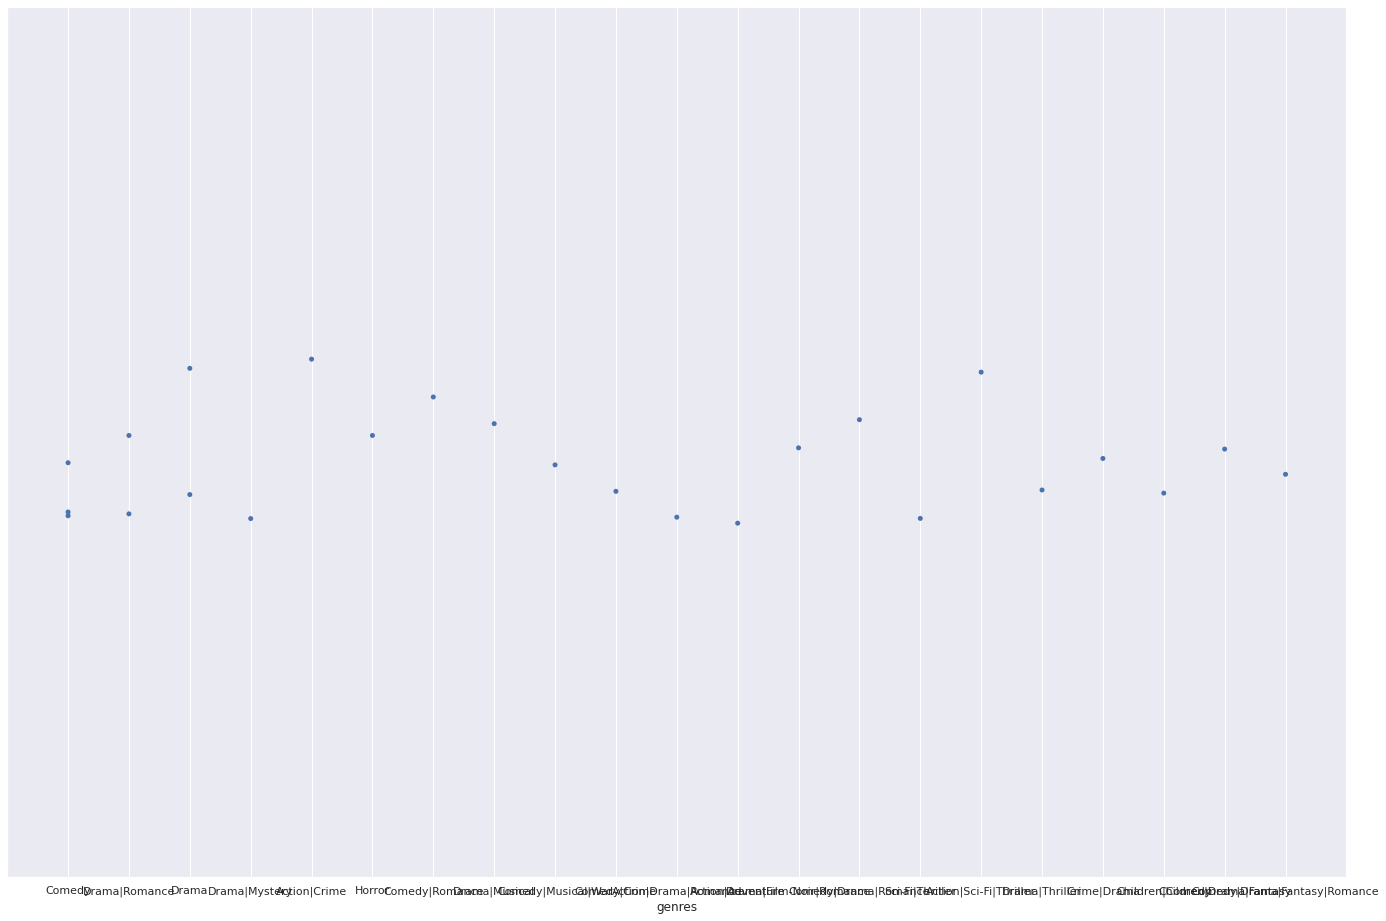

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(24,16)})
sns.stripplot(data=test_user_movies, x="genres")

In [ ]:
separated_genres = test_user_movies['genres'].str.split('|', expand=True)
separated_genres.rename(columns={0:'genre1', 1:'genre2', 2:'genre3', 3:'genre4'}, inplace=True)
separated_genres.insert(loc=0, column='movieId', value=test_user_movies['movieId'])

separated_genres

,movieId,genre1,genre2,genre3,genre4
0,203,Comedy,None,None,None
1,249,Drama,Romance,None,None
18,3100,Drama,None,None,None
17,2686,Drama,Mystery,None,None
16,2616,Action,Crime,None,None
15,1982,Horror,None,None,None
14,1441,Comedy,Romance,None,None
13,1298,Drama,Musical,None,None
12,1256,Comedy,Musical,War,None
11,1125,Comedy,Crime,None,None


In [ ]:
new_test_user_movies = test_user_movies.merge(separated_genres, how='right')
new_test_user_movies

,movieId,title,genres,genre1,genre2,genre3,genre4
0,203,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,Comedy,None,None,None
1,249,Immortal Beloved (1994),Drama|Romance,Drama,Romance,None,None
2,3100,"River Runs Through It, A (1992)",Drama,Drama,None,None,None
3,2686,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery,Drama,Mystery,None,None
4,2616,Dick Tracy (1990),Action|Crime,Action,Crime,None,None
5,1982,Halloween (1978),Horror,Horror,None,None,None
6,1441,Benny & Joon (1993),Comedy|Romance,Comedy,Romance,None,None
7,1298,Pink Floyd: The Wall (1982),Drama|Musical,Drama,Musical,None,None
8,1256,Duck Soup (1933),Comedy|Musical|War,Comedy,Musical,War,None
9,1125,"Return of the Pink Panther, The (1975)",Comedy|Crime,Comedy,Crime,None,None


In [ ]:
# Converting categorical variables to numerical

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
 
label = le.fit_transform(new_test_user_movies['genre1'])
new_test_user_movies.drop("genre1", axis=1, inplace=True)
new_test_user_movies["genre1"] = label

label = le.fit_transform(new_test_user_movies['genre2'])
new_test_user_movies.drop("genre2", axis=1, inplace=True)
new_test_user_movies["genre2"] = label

label = le.fit_transform(new_test_user_movies['genre3'])
new_test_user_movies.drop("genre3", axis=1, inplace=True)
new_test_user_movies["genre3"] = label

label = le.fit_transform(new_test_user_movies['genre4'])
new_test_user_movies.drop("genre4", axis=1, inplace=True)
new_test_user_movies["genre4"] = label

# Mapping information of int labels to corresponding class names
classes_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

new_test_user_movies

,movieId,title,genres,genre1,genre2,genre3,genre4
0,203,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,2,10,4,1
1,249,Immortal Beloved (1994),Drama|Romance,4,7,4,1
2,3100,"River Runs Through It, A (1992)",Drama,4,10,4,1
3,2686,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery,4,6,4,1
4,2616,Dick Tracy (1990),Action|Crime,0,2,4,1
5,1982,Halloween (1978),Horror,5,10,4,1
6,1441,Benny & Joon (1993),Comedy|Romance,2,7,4,1
7,1298,Pink Floyd: The Wall (1982),Drama|Musical,4,5,4,1
8,1256,Duck Soup (1933),Comedy|Musical|War,2,5,3,1
9,1125,"Return of the Pink Panther, The (1975)",Comedy|Crime,2,2,4,1


Text(1.8, 9.7, 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)')

Text(2.15, 10.1, 'Airheads (1994)')

Text(2.05, 10.3, "Ferris Bueller's Day Off (1986)")

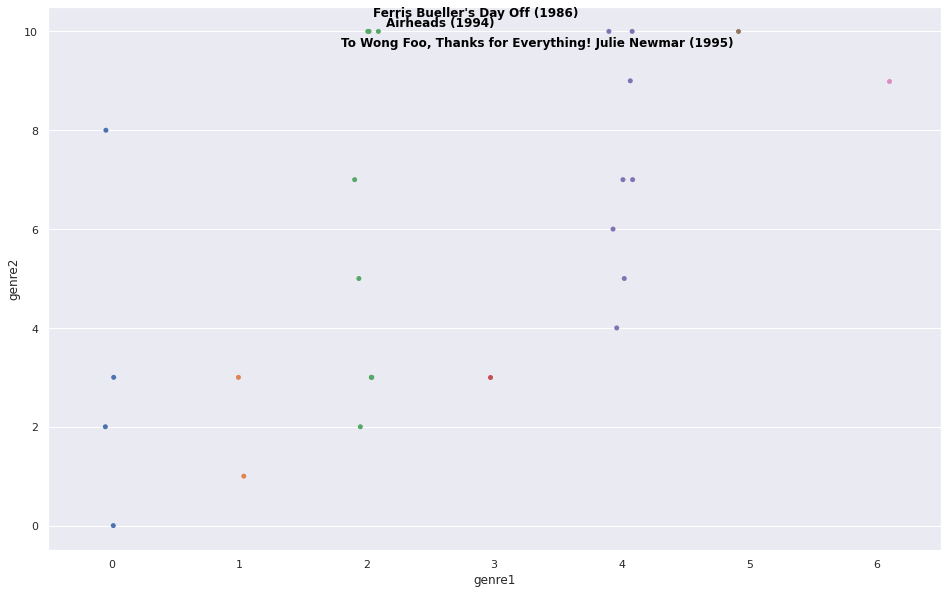

In [ ]:
import matplotlib as plt

sns.set(rc={'figure.figsize':(16,10)})
ax = sns.stripplot(data=new_test_user_movies, x="genre1", y="genre2")

for line in new_test_user_movies.index:

  if line == 0:
     ax.text(new_test_user_movies.genre1[line] - 0.2, new_test_user_movies.genre2[line] - 0.3, new_test_user_movies.title[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')
     
  elif line == 17:
     ax.text(new_test_user_movies.genre1[line] + 0.15, new_test_user_movies.genre2[line] + 0.1, new_test_user_movies.title[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')
     
  elif line == 23:
     ax.text(new_test_user_movies.genre1[line] + 0.05, new_test_user_movies.genre2[line] + 0.3, new_test_user_movies.title[line], 
             horizontalalignment='left', size='medium', color='black', weight='semibold')

## User-based Collaborative Filtering

In [22]:
# Using Pearson Correlation to find the similarities of users

users_similarities = urm_train_mean.T.corr()
users_similarities

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.883034,0.754584,0.611134,0.801741,0.341177,0.755502,0.796065,0.862503,0.751186,...,0.885241,0.578624,0.324777,0.678947,0.673846,0.561658,0.692672,0.273524,0.844619,0.756513
2,0.883034,1.000000,0.944060,0.702236,0.869302,0.364644,0.882921,0.844550,0.977176,0.853102,...,0.929123,0.616398,0.510584,0.781293,0.917600,0.739878,0.880218,0.453119,0.947594,0.812271
3,0.754584,0.944060,1.000000,0.618959,0.828352,0.340100,0.869438,0.815382,0.935995,0.894913,...,0.881118,0.584752,0.419913,0.746950,0.877815,0.584129,0.820650,0.416485,0.908576,0.766246
4,0.611134,0.702236,0.618959,1.000000,0.606626,0.297988,0.665356,0.634298,0.684186,0.687006,...,0.564884,0.503877,0.326507,0.572066,0.693178,0.416124,0.598935,0.217807,0.692694,0.518952
5,0.801741,0.869302,0.828352,0.606626,1.000000,0.311048,0.821846,0.774484,0.857365,0.818198,...,0.866137,0.576177,0.450786,0.695672,0.789619,0.690018,0.776123,0.417631,0.856723,0.718491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.561658,0.739878,0.584129,0.416124,0.690018,0.254373,0.600314,0.677463,0.729947,0.475709,...,0.753394,0.511151,0.429012,0.640527,0.595323,1.000000,0.534525,0.328599,0.734439,0.578556
607,0.692672,0.880218,0.820650,0.598935,0.776123,0.393489,0.799849,0.785068,0.879847,0.748637,...,0.882110,0.611224,0.388338,0.711069,0.814028,0.534525,1.000000,0.338016,0.859412,0.695432
608,0.273524,0.453119,0.416485,0.217807,0.417631,0.186757,0.296804,0.472088,0.432813,0.311148,...,0.484362,0.406507,0.179710,0.394594,0.368166,0.328599,0.338016,1.000000,0.454902,0.304431


In [23]:
TOP_N_SIMILAR = 10
SIMILARITY_THRESHOLD = 0.3

# Removing the actual test user from similar users list
users_similarities.drop(index=USER_TO_TEST, inplace=True)

# Getting top n similar users
similar_users = users_similarities[users_similarities[USER_TO_TEST] > SIMILARITY_THRESHOLD][USER_TO_TEST].sort_values(ascending=False)[:TOP_N_SIMILAR]

print(f'The similar users for user {USER_TO_TEST} are:\n\n', similar_users)

The similar users for user 53 are:

 userId
236    0.991750
360    0.991631
306    0.991631
106    0.991631
252    0.991631
352    0.991631
578    0.991631
320    0.991631
184    0.991631
496    0.991631
Name: 53, dtype: float64


In [24]:
# Normalization for non-filled urm matrix
urm_train_mean_nofill = urm_train_mean_nofill.subtract(urm_train_mean_nofill.mean(axis=1), axis = 'rows')

# Finding movies that the test user watched
test_user_watched = urm_train_mean_nofill[urm_train_mean_nofill.index == USER_TO_TEST].dropna(axis=1, how='all')

# Finding movies that similar users watched and removing movies that none of the similar users watched
similar_users_watched = urm_train_mean_nofill[urm_train_mean_nofill.index.isin(similar_users.index)].dropna(axis=1, how='all')

# Removing test user's watched movies from the similar users watched movie list
similar_users_watched.drop(test_user_watched.columns, axis=1, inplace=True, errors='ignore')

In [25]:
item_score = {}

for i in similar_users_watched.columns:
  
  movie_rating = similar_users_watched[i]
  total = 0
  count = 0

  # Loop through similar users 
  for u in similar_users.index:
    if pd.isna(movie_rating[u]) == False:
      score = similar_users[u] * movie_rating[u]
      total += score
      count +=1

      item_score[i] = total / count

item_score = pd.DataFrame(item_score.items(), columns=['movieId', 'movie_score'])
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Getting the movies title by merging
recommended_movies_ubcf = ranked_item_score[['movieId']].merge(movies, how='inner', on='movieId').head(RECOMMENDATION_NUM)

## Quick View of Results

### Global Parameters

---


USER_TO_TEST: 53

RECOMMENDATION_NUM: 5

In [26]:
# The movies that test user has already rated
train[train['userId'] == USER_TO_TEST][['userId', 'movieId', 'rating']].merge(movies, how='inner', on='movieId')

,userId,movieId,rating,title,genres
0,53,1441,5.0,Benny & Joon (1993),Comedy|Romance
1,53,2616,5.0,Dick Tracy (1990),Action|Crime
2,53,748,5.0,"Arrival, The (1996)",Action|Sci-Fi|Thriller
3,53,413,5.0,Airheads (1994),Comedy
4,53,2686,5.0,"Red Violin, The (Violon rouge, Le) (1998)",Drama|Mystery
5,53,1982,5.0,Halloween (1978),Horror
6,53,1298,5.0,Pink Floyd: The Wall (1982),Drama|Musical
7,53,880,5.0,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller
8,53,203,5.0,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
9,53,922,5.0,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance


### Item-based Collaborative F. (filling by 0)

In [27]:
recommended_movies_svd_0

,movieId,title,genres
275,318,"Shawshank Redemption, The (1994)",Crime|Drama
2092,2804,"Christmas Story, A (1983)",Children|Comedy
986,1302,Field of Dreams (1989),Children|Drama|Fantasy
2177,2918,Ferris Bueller's Day Off (1986),Comedy
2085,2797,Big (1988),Comedy|Drama|Fantasy|Romance


### Item-based Collaborative F. (filling by mean)

In [28]:
recommended_movies_svd_mean

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### User-based Collaborative F. (using Pearson Correlation) 

In [29]:
recommended_movies_ubcf

,movieId,title,genres
0,103372,"Heat, The (2013)",Action|Comedy|Crime
1,69406,"Proposal, The (2009)",Comedy|Romance
2,134368,Spy (2015),Action|Comedy|Crime
3,858,"Godfather, The (1972)",Crime|Drama
4,904,Rear Window (1954),Mystery|Thriller


### Personalization Rate of Results

In [30]:
populars_svd_0 = ratings[ratings['movieId'].isin(recommended_movies_svd_0['movieId'])].value_counts('movieId')
populars_svd_0.mean()

125.6

In [31]:
populars_svd_mean = ratings[ratings['movieId'].isin(recommended_movies_svd_mean['movieId'])].value_counts('movieId')
populars_svd_mean.mean()

86.6

In [32]:
recommended_movies_ubcf = ratings[ratings['movieId'].isin(recommended_movies_ubcf['movieId'])].value_counts('movieId')
recommended_movies_ubcf.mean()

62.8

## Two Metrics on Different Example

In [ ]:
!pip install surprise
!pip install recmetrics 

In [34]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()
algo.fit(trainset)

test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']

test.head(20)

,userId,movieId,actual,cf_predictions
0,352,139385,5.0,3.767883
1,82,6383,3.0,2.804287
2,580,508,4.0,3.404166
3,437,648,3.0,3.558218
4,140,8970,3.5,3.701927
5,368,1396,3.0,2.842563
6,414,23,2.0,3.037629
7,160,1022,5.0,2.960571
8,249,88235,4.0,3.593340
9,599,555,3.5,2.910199


In [35]:
import recmetrics

print("RMSE: ", round(recmetrics.rmse(test.actual, test.cf_predictions),4), sep='')

RMSE: 0.8706


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


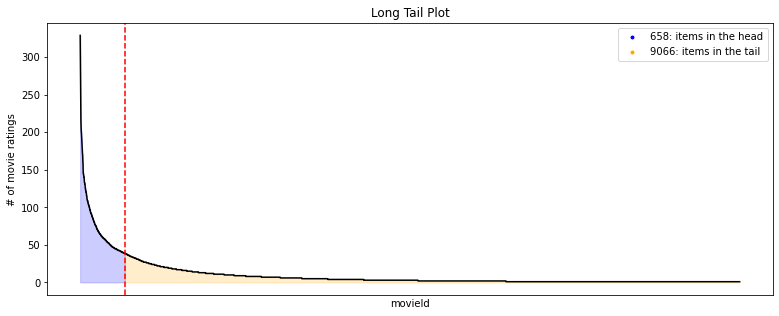

In [36]:
import matplotlib.pyplot as plt
import recmetrics

fig = plt.figure(figsize=(13, 5))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)